In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import splitfolders
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Add, GlobalAveragePooling2D, ZeroPadding2D, Activation, Input, MaxPool2D, concatenate, Reshape, Lambda, Flatten, BatchNormalization, LeakyReLU
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam as Adam
from tensorflow.keras import layers
import shutil
from tensorflow.keras.metrics import MeanIoU
import tensorflow_ranking as tfr
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers
import matplotlib.patches as patches
from tensorflow.keras.models import load_model

2022-08-23 17:43:28.207006: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2022-08-23 17:43:29.691517: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-23 17:43:29.692765: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 17:43:29.694853: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-23 17:43:29.723168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 17:43:29.723500: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 na

In [3]:
# input_data_path =r'C:/Users/conm/Desktop/Stenosis-Project/Stenosis detection/input'

train_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/train/stenosis'

# train_path1 = r'C:\Users\conm\Desktop\Stenosis-Project\train_images'

test_path = '/home/lunet/conm/Desktop/Stenosis-Project/test_images'

val_path = '/home/lunet/conm/Desktop/Stenosis-Project/output/val/stenosis'

train_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/train/stenosis'

val_path2 = '/home/lunet/conm/Desktop/Stenosis-Project/output2/val/stenosis'

# train_path2 = r'C:\Users\conm\Desktop\Stenosis-Project\Dataset_Reduced\train\images'

In [4]:
train_labels_csv = pd.read_csv('train_labels.csv')
train_labels_csv_3 = pd.read_csv('train_labels_3.csv')
len(train_labels_csv_3)

5993

In [5]:
test_labels_csv = pd.read_csv('test_labels.csv')

In [6]:
val_labels_csv = pd.read_csv('val_labels.csv')
val_labels_csv_2 = pd.read_csv('val_labels_2.csv')

In [7]:
train_images = []
train_targets = []

val_images = []
val_targets = []

test_images = []
test_targets = []

In [8]:
for index, row in train_labels_csv_3.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(train_path2,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]

    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    xmin = int(xmin * x_scale)
    ymin = int(ymin * y_scale)
    xmax = int(xmax * x_scale)
    ymax = int(ymax * y_scale)
    # print(x, y, xmax, ymax)
    
    train_images.append(pic)
    train_targets.append((xmin, ymin, xmax, ymax))

In [25]:
train_targets[0]

array([ 97.,  76., 105.,  81.], dtype=float32)

In [9]:
for index, row in val_labels_csv_2.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(val_path2,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]

    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    xmin = int(xmin * x_scale)
    ymin = int(ymin * y_scale)
    xmax = int(xmax * x_scale)
    ymax = int(ymax * y_scale)
    # print(x, y, xmax, ymax)

    val_images.append(pic)
    val_targets.append((xmin, ymin, xmax, ymax))

In [10]:
for index, row in test_labels_csv.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(test_path,filename))
    
    x = pic.shape[0]
    y = pic.shape[1]

    img_Target_size = 224
    x_scale = img_Target_size / x
    y_scale = img_Target_size / y

    pic = cv2.resize(pic, (img_Target_size, img_Target_size))

    xmin = int(xmin * x_scale)
    ymin = int(ymin * y_scale)
    xmax = int(xmax * x_scale)
    ymax = int(ymax * y_scale)
    # print(x, y, xmax, ymax)

    test_images.append(pic)
    test_targets.append((xmin, ymin, xmax, ymax))

In [11]:
test_targets[0]

(80, 103, 91, 111)

In [12]:
train_images = np.array(train_images).astype('float32')
train_targets = np.array(train_targets).astype('float32')

In [13]:
val_images = np.array(val_images).astype('float32')
val_targets = np.array(val_targets).astype('float32')

In [14]:
test_images = np.array(test_images).astype('float32')
test_targets = np.array(test_targets).astype('float32')

In [15]:
val_images /= 255.0
train_images /= 255.0
test_images /= 255.0

In [16]:
test_targets[0]

array([ 80., 103.,  91., 111.], dtype=float32)

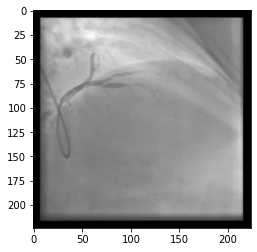

In [17]:
plt.imshow(val_images[0])

In [18]:
train_targets.shape

(5993, 4)

In [19]:
dataGenerator = ImageDataGenerator()

In [20]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [21]:
visible = Input(shape=(224, 224, 3))

x = Conv2D(64, 3, padding='same', name='conv_1')(visible)
x = LeakyReLU(alpha=0.1)(x)
# x = RandomFlip(mode='horizontal', seed=None)(x)
x = BatchNormalization()(x)
block_1 = MaxPool2D(3)(x)

x = Conv2D(64, (3, 3), padding='same', name='conv_2')(block_1)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
block_2 = Add()([x, block_1])

x = Conv2D(64, (3, 3), padding='same', name='conv_3')(block_2)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_3 = Add()([x, block_2])

x = Conv2D(64, (3, 3), padding='same', name='conv_4')(block_3)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_4 = Add()([x, block_3])

x = Conv2D(64, (3, 3), padding='same', name='conv_5')(block_4)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_5 = Add()([x, block_4])

x = Conv2D(64, (3, 3), padding='same', name='conv_6')(block_5)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_6 = Add()([x, block_5])

x = Conv2D(64, (3, 3), padding='same', name='conv_7')(block_6)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_7 = Add()([x, block_6])

x = Conv2D(64, (3, 3), padding='same', name='conv_8')(block_7)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_8 = Add()([x, block_7])

x = Conv2D(64, (3, 3), padding='same', name='conv_9')(block_8)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_9 = Add()([x, block_8])

x = Conv2D(64, (3, 3), padding='same', name='conv_10')(block_9)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_10 = Add()([x, block_9])

x = Conv2D(64, (3, 3), padding='same', name='conv_11')(block_10)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_11 = Add()([x, block_10])

x = Conv2D(64, (3, 3), padding='same', name='conv_12')(block_11)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_12 = Add()([x, block_11])

x = Conv2D(64, (3, 3), padding='same', name='conv_13')(block_12)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_13 = Add()([x, block_12])

x = Conv2D(64, (3, 3), padding='same', name='conv_14')(block_13)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
# x = MaxPool2D(pool_size=(2, 2), padding='same')(x)
block_14 = Add()([x, block_13])

glob_layer = GlobalAveragePooling2D()(block_14)
# flat_layer = Flatten()(block_14)
x = Dropout(0.35)(glob_layer)
x = Dense(256, kernel_regularizer=regularizers.l2(0.1))(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.35)(x)

outputs = Dense(4)(x)

model = Model(visible, outputs, name='Functional_Model')

model.summary()

Model: "Functional_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 224, 224, 64) 0           conv_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         leaky_re_lu[0][0]                
___________________________________________________________________________________

2022-08-23 17:43:38.818578: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-23 17:43:38.818735: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-23 17:43:38.819174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-08-23 17:43:38.819214: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-23 17:43:38.819238: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-23 17:43:38.819255: I tensorflow/stream_executor/plat

In [22]:
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', metrics=[tfr.keras.metrics.MeanAveragePrecisionMetric()])


In [23]:
keras.backend.clear_session()
np.random.seed(15)
tf.random.set_seed(15)

model_history = model.fit(dataGenerator.flow(train_images, train_targets, batch_size=64),
                            validation_data=(val_images, val_targets), 
                            epochs=250, callbacks=[es], verbose=1, shuffle=True)

Epoch 1/250


2022-08-23 17:43:39.146480: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-23 17:43:39.167110: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-08-23 17:43:40.779270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-23 17:43:40.892260: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-08-23 17:43:41.472802: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-08-23 17:43:41.523239: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


94/94 [==============================] - ETA: 0s - loss: 14.3185 - mean_average_precision_metric: 1.0000

2022-08-23 17:44:08.006388: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 902565888 exceeds 10% of free system memory.


94/94 [==============================] - 35s 313ms/step - loss: 14.2678 - mean_average_precision_metric: 1.0000 - val_loss: 7.8984 - val_mean_average_precision_metric: 1.0000
Epoch 2/250
94/94 [==============================] - 22s 230ms/step - loss: 3.6068 - mean_average_precision_metric: 1.0000 - val_loss: 5.6597 - val_mean_average_precision_metric: 1.0000
Epoch 3/250
94/94 [==============================] - 22s 232ms/step - loss: 1.8744 - mean_average_precision_metric: 1.0000 - val_loss: 5.1275 - val_mean_average_precision_metric: 1.0000
Epoch 4/250
66/94 [====================>.........] - ETA: 5s - loss: 1.5222 - mean_average_precision_metric: 1.0000

KeyboardInterrupt: 

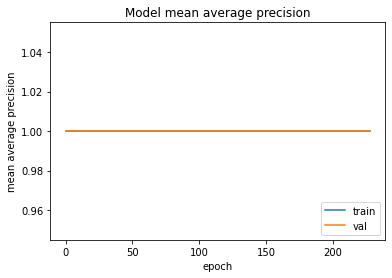

In [ ]:
plt.plot(model_history.history['mean_average_precision_metric'])
plt.plot(model_history.history['val_mean_average_precision_metric'])
plt.title('Model mean average precision')
plt.ylabel('mean average precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
model.evaluate(test_images, test_targets, verbose=1, batch_size=32)


27/27 [==============================] - 5s 189ms/step - loss: 0.0449 - mean_average_precision_metric: 1.0000


[0.04490933567285538, 1.0]

In [ ]:
model.save('dummy.h5')

18144 23072 20608 24864
10304 10080 12768 12768
28896 21056 30912 23744
12544 13440 18592 15456
20160 11200 21952 14336


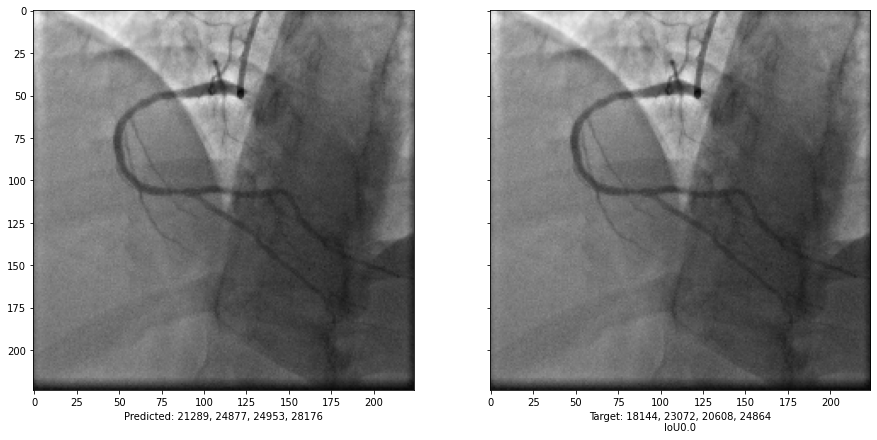

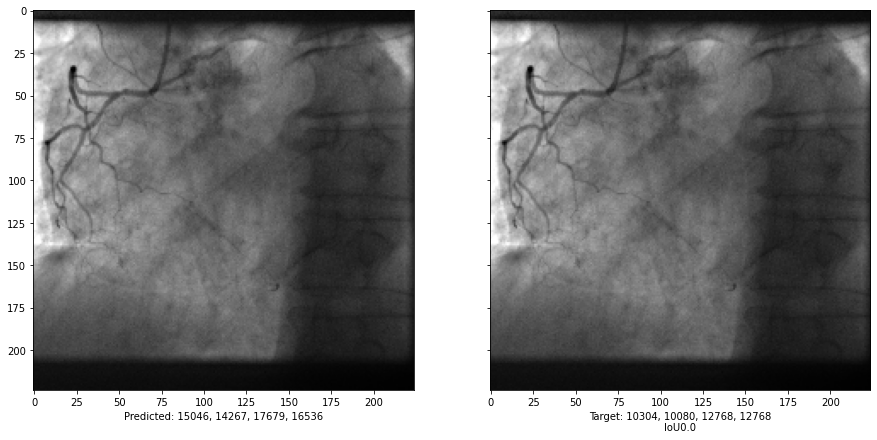

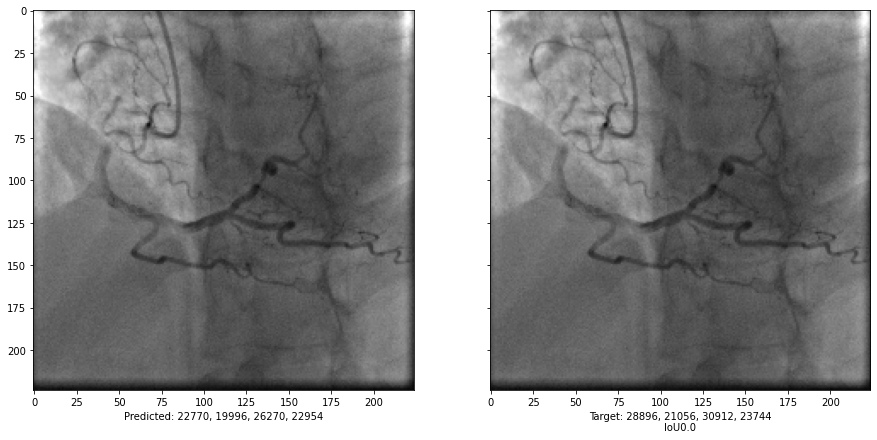

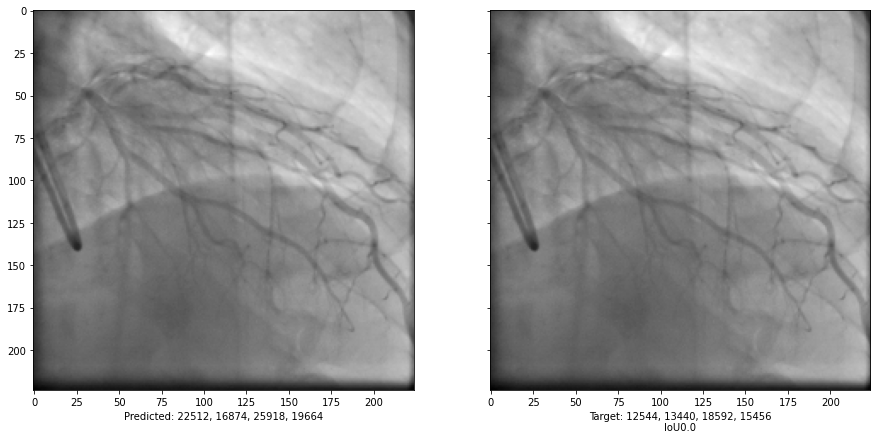

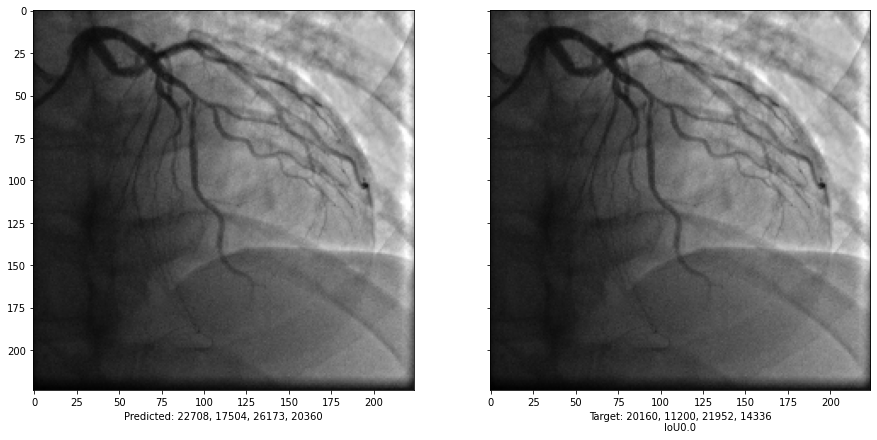

In [ ]:
model_load = load_model('dummy.h5')
# To calculate IoU (intersection over union, given two bounding boxes)
# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by  the interesection area

    # return ioU
    return intersection_area / float (
        box_predicted_area + box_truth_area - intersection_area
    )


i, mean_iou = 0, 0

# Compare results for 10 images in the test set
for input_image in test_images[:5]:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15), sharey=True, sharex=True)
    im = input_image
    
    # plt.margins(x=0, y=0)

    # Display the image
    ax1.imshow(im)
    ax2.imshow(im)

    input_image = cv2.resize(
        input_image, (224, 224)
    )
    input_image = np.expand_dims(input_image, axis=0)
    preds = model_load.predict(input_image)[0]

    (h, w) = (im).shape[0:2]

    top_left_x, top_left_y = int(preds[0] * w), int(preds[1] * h)

    bottom_right_x, bottom_right_y = int(preds[2] * w), int(preds[3] * h)

    box_predicted = [top_left_x, top_left_y, bottom_right_x, bottom_right_y]
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax1.add_patch(rect)
    ax1.set_xlabel(
        "Predicted: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
    )

    top_left_x, top_left_y = int(test_targets[i][0] * w), int(test_targets[i][1] * h)

    bottom_right_x, bottom_right_y = int(test_targets[i][2] * w), int(test_targets[i][3] * h)

    box_truth = top_left_x, top_left_y, bottom_right_x, bottom_right_y

    mean_iou += bounding_box_intersection_over_union(box_predicted, box_truth)
    # Create the bounding box
    rect = patches.Rectangle(
        (top_left_x, top_left_y),
        bottom_right_x - top_left_x,
        bottom_right_y - top_left_y,
        facecolor="none",
        edgecolor="red",
        linewidth=1,
    )
    # Add the bounding box to the image
    ax2.add_patch(rect)
    # print(top_left_x, top_left_y, bottom_right_x,bottom_right_y)
    ax2.set_xlabel(
        "Target: "
        + str(top_left_x)
        + ", "
        + str(top_left_y)
        + ", "
        + str(bottom_right_x)
        + ", "
        + str(bottom_right_y)
        + "\n"
        + "IoU"
        + str(bounding_box_intersection_over_union(box_predicted, box_truth))
    )
    print(top_left_x, top_left_y, bottom_right_x,bottom_right_y)
    # type(top_left_x)
    i = i + 1
plt.show()

In [ ]:
val_targets[0][0]

78.0

/tmp/ipykernel_17612/3736783874.py:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  image = cv2.rectangle(test_images[0], (test_targets[0][0],test_targets[0][1]), (test_targets[0][2],test_targets[0][3]), color=(0,0,0))


<function matplotlib.pyplot.show(close=None, block=None)>

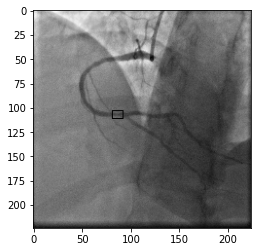

In [ ]:
image = cv2.rectangle(test_images[0], (test_targets[0][0],test_targets[0][1]), (test_targets[0][2],test_targets[0][3]), color=(0,0,0))
plt.imshow(image.astype(np.uint8))
plt.show

In [ ]:
def drawBox(boxes, image):
    for i in range(0, len(boxes)):
        # changed color and width to make it visible
        cv2.rectangle(image, (boxes[i][2], boxes[i][3]), (boxes[i][4], boxes[i][5]), (255, 0, 0), 1)
    plt.imshow("img", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


def cvTest():
    # imageToPredict = cv2.imread("img.jpg", 3)
    imageToPredict = cv2.imread("/home/lunet/conm/Desktop/Stenosis-Project/output2/val/stenosis/14_002_5_0016.bmp", 3)
    print(imageToPredict.shape)

    # Note: flipped comparing to your original code!
    # x_ = imageToPredict.shape[0]
    # y_ = imageToPredict.shape[1]
    y_ = imageToPredict.shape[0]
    print(y_)
    x_ = imageToPredict.shape[1]

    targetSize = 224
    x_scale = targetSize / x_
    y_scale = targetSize / y_
    print(x_scale, y_scale)
    img = cv2.resize(imageToPredict, (targetSize, targetSize));
    print(img.shape)
    img = np.array(img);

    # original frame as named values
    (origLeft, origTop, origRight, origBottom) = (179,148,206,167)

    x = float(np.round(origLeft * x_scale))
    y = float(np.round(origTop * y_scale))
    xmax = float(np.round(origRight * x_scale))
    ymax = float(np.round(origBottom * y_scale))
    print(x, y, xmax, ymax)
    # Box.drawBox([[1, 0, x, y, xmax, ymax]], img)
    # drawBox([[1, 0, x, y, xmax, ymax]], img)


cvTest()

(512, 512, 3)
512
0.4375 0.4375
(224, 224, 3)
78.0 65.0 90.0 73.0


In [ ]:
val_images = []
val_targets = []

In [ ]:
for index, row in val_labels_csv_2.iterrows():
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    pic = cv2.imread(os.path.join(val_path2,filename))
    # Resize the images according to the original image size dimensions
    pic = cv2.resize(pic, (224, 224))


    # xmin *= 224
    # ymin *= 224
    # xmax *= 224
    # ymax *= 224
    
    val_images.append(pic)
    val_targets.append((xmin, ymin, xmax, ymax))

In [ ]:
val_targets[0]

(78.0, 65.0, 90.0, 73.0)

In [ ]:
val_targets[0]

array([78., 65., 90., 73.], dtype=float32)

In [ ]:
val_images = np.array(val_images).astype('float32')
val_targets = np.array(val_targets).astype('float32')